
#### Dataset
We start by downloading historical stock price data for Apple (AAPL) from Yahoo Finance. We specifically download daily closing prices and compute daily returns. Daily returns are calculated as the percentage change in closing prices from one day to the next. This dataset is used to train our MDN.

#### Model Architecture
The MDN consists of three main components:

1. **Neural Network Layers**:
   - **Input Layer**: Accepts a window of past returns (features).
   - **Hidden Layers**: Two fully connected (dense) layers with ReLU activation functions.
   - **Output Layer**: Outputs parameters for the mixture model: probabilities (`pi`), standard deviations (`sigma`), and means (`mu`) for each component in the mixture.

2. **Mixture Components**:
   - Each component in the mixture model represents a Gaussian distribution. The network outputs probabilities (`pi`) for each component, which determine the likelihood of each Gaussian distribution contributing to the prediction.

#### Loss Function
The loss function used is based on maximum likelihood estimation for the mixture model:
\[ \text{loss} = -\frac{1}{N} \sum_{i=1}^{N} \log \left( \sum_{j=1}^{M} \pi_{ij} \cdot \mathcal{N}(y_i | \mu_{ij}, \sigma_{ij}) \right) \]
where:
- \( N \) is the batch size.
- \( M \) is the number of mixture components (in this case, 5).
- \( \pi_{ij} \) is the probability of the \( j \)-th component for the \( i \)-th sample.
- \( \mu_{ij} \) and \( \sigma_{ij} \) are the mean and standard deviation of the \( j \)-th component for the \( i \)-th sample.
- \( y_i \) is the true target value (next day return) for the \( i \)-th sample.

The goal is to maximize the likelihood of observing the true targets given the predicted mixture of Gaussian distributions.

#### Training
The model is trained using Adam optimizer with a learning rate of 0.001. During training, the network learns to adjust its parameters (weights and biases) to minimize the negative log-likelihood loss.

### Why Use a Probabilistic Model (MDN) Here?

Using a probabilistic model like MDN makes sense in this scenario for several reasons:

- **Capturing Uncertainty**: Stock returns are inherently uncertain and influenced by numerous factors. A probabilistic model allows us to quantify and incorporate this uncertainty into predictions.
  
- **Multi-Modal Distributions**: Stock returns often exhibit complex patterns that cannot be accurately captured by a single deterministic model. MDN allows the model to learn multiple modes (clusters) in the data, each represented by a Gaussian distribution.

- **Richer Predictive Distribution**: Instead of predicting a single point estimate (like in deterministic models), MDN provides a full predictive distribution. This distribution not only gives a mean estimate but also provides insights into the variability and likelihood of different outcomes.

- **Risk Management**: For applications like portfolio management or risk assessment, understanding the uncertainty in predictions is crucial. MDN provides a tool to quantify and manage this risk effectively.

In summary, MDNs offer a flexible framework for modeling complex, uncertain data distributions, making them particularly suitable for predicting stock returns where uncertainty and multiple potential outcomes are inherent.



[*********************100%%**********************]  1 of 1 completed


NaN detected in outputs at epoch 0
Epoch 0, Loss: -0.02592719905078411
NaN detected in outputs at epoch 1
NaN detected in outputs at epoch 2
NaN detected in outputs at epoch 3
NaN detected in outputs at epoch 4
NaN detected in outputs at epoch 5
NaN detected in outputs at epoch 6
NaN detected in outputs at epoch 7
NaN detected in outputs at epoch 8
NaN detected in outputs at epoch 9
NaN detected in outputs at epoch 10
NaN detected in outputs at epoch 11
NaN detected in outputs at epoch 12
NaN detected in outputs at epoch 13
NaN detected in outputs at epoch 14
NaN detected in outputs at epoch 15
NaN detected in outputs at epoch 16
NaN detected in outputs at epoch 17
NaN detected in outputs at epoch 18
NaN detected in outputs at epoch 19
NaN detected in outputs at epoch 20
NaN detected in outputs at epoch 21
NaN detected in outputs at epoch 22
NaN detected in outputs at epoch 23
NaN detected in outputs at epoch 24
NaN detected in outputs at epoch 25
NaN detected in outputs at epoch 26
Na

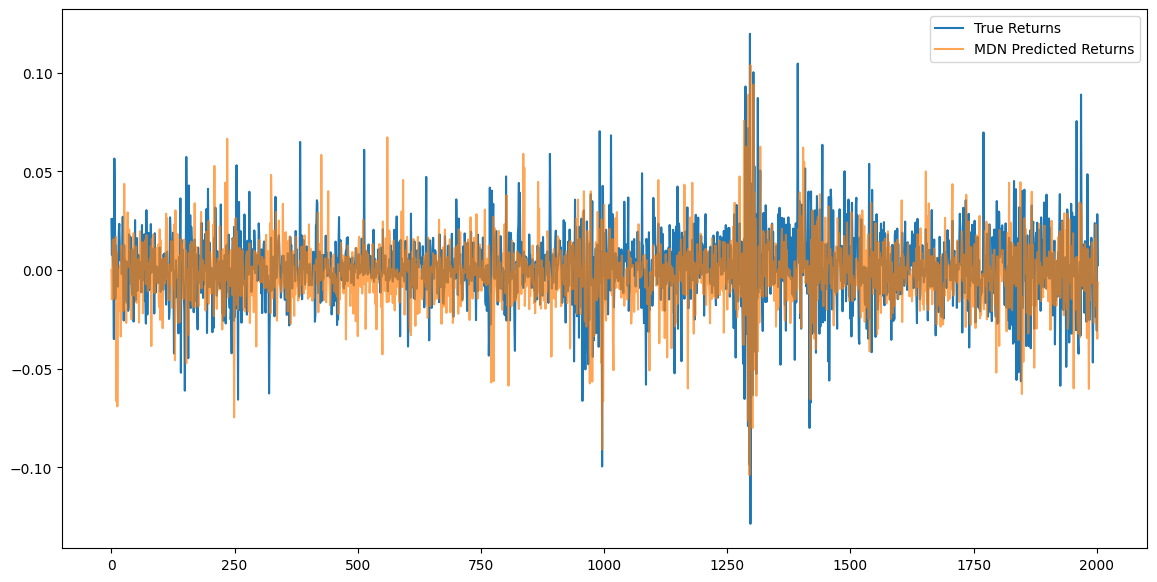

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Download stock price data
stock_data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')

# Calculate daily returns
stock_data['Return'] = stock_data['Close'].pct_change().dropna()

# Create features and targets
window_size = 10
features, targets = [], []
for i in range(window_size, len(stock_data) - 1):
    features.append(stock_data['Return'].values[i-window_size:i])
    targets.append(stock_data['Return'].values[i+1])

features = np.array(features)
targets = np.array(targets)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

# Create DataLoader
dataset = TensorDataset(features_tensor, targets_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

import torch.nn as nn
import torch.nn.functional as F

class MDN(nn.Module):
    def __init__(self, input_dim, output_dim, num_mixtures):
        super(MDN, self).__init__()
        self.num_mixtures = num_mixtures

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_mixtures * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        pi = x[:, :self.num_mixtures]
        sigma = x[:, self.num_mixtures:2*self.num_mixtures]
        mu = x[:, 2*self.num_mixtures:]

        pi = F.softmax(pi, dim=1)
        sigma = torch.exp(sigma)

        return pi, sigma, mu

def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    y = y.expand_as(mu)
    log_prob = m.log_prob(y)
    log_prob = torch.logsumexp(log_prob + torch.log(pi), dim=1)
    return -torch.mean(log_prob)

# Model and optimizer
model = MDN(input_dim=window_size, output_dim=1, num_mixtures=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1000
for epoch in range(epochs):
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pi, sigma, mu = model(batch_x)

        if torch.isnan(pi).any() or torch.isnan(sigma).any() or torch.isnan(mu).any():
            print(f"NaN detected in outputs at epoch {epoch}")
            continue

        sigma = torch.clamp(sigma, min=1e-6)  # Clamp sigma to prevent it from being too small

        loss = mdn_loss(pi, sigma, mu, batch_y)

        if torch.isnan(loss).any():
            print(f"NaN detected in loss at epoch {epoch}")
            continue

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict using the trained MDN
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(features, dtype=torch.float32)
    pi, sigma, mu = model(x_test_tensor)

pi = pi.numpy()
sigma = sigma.numpy()
mu = mu.numpy()

# Sample from the predicted mixture model
samples = np.zeros(targets.shape)
for i in range(targets.shape[0]):
    if np.isnan(pi[i]).any():
        print(f"NaN detected in pi at index {i}")
        continue

    component = np.random.choice(np.arange(5), p=pi[i])
    samples[i] = np.random.normal(mu[i, component], sigma[i, component])

plt.figure(figsize=(14, 7))
plt.plot(targets, label='True Returns')
plt.plot(samples, label='MDN Predicted Returns', alpha=0.7)
plt.legend()
plt.show()
